Import delle librerie, funzioni di utilità

In [62]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import Aer, execute
from qiskit.extensions import Initialize
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import partial_trace, Statevector, random_statevector, Operator
from qiskit_textbook.tools import simon_oracle
import numpy as np
import math

In [2]:
def create_bell_state(circuit, q1, q2):
    circuit.h(q1)
    circuit.cnot(q1, q2)

def create_bell_state(circuit, register):
    circuit.h(register[0])
    circuit.cnot(register[0], register[1])

def teleport_gates(circuit, alice_qbit, alice_ent):
    circuit.cnot(alice_qbit, alice_ent)
    circuit.h(alice_qbit)


def swap(circuit, q1, q2):
    circuit.cnot(q1, q2)
    circuit.cnot(q2,q1)
    circuit.cnot(q1, q2)

# Deutsch's
Classifico un funzione in bilanciata o costante

$
f(x):\{0,1\} \mapsto \{0,1\} 
$

- Bilanciata $ f(0) \neq f(1) $
- Costante $ f(0) = f(1) $

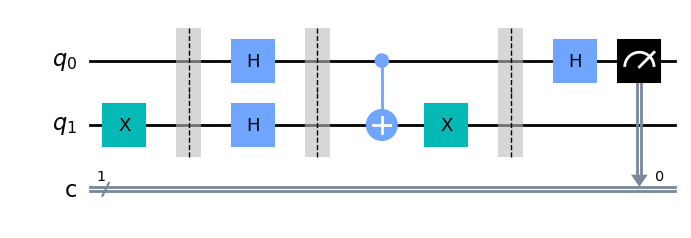

In [38]:
reg = QuantumRegister(2, 'q')
c = ClassicalRegister(1,  'c')
qc = QuantumCircuit(reg, c)



qc.x(1)
qc.barrier()
qc.h(reg)
qc.barrier()



qc.cnot(0,1)
qc.x(1)

qc.barrier()
qc.h(0)
qc.measure(0, c)


qc.draw(output='mpl')

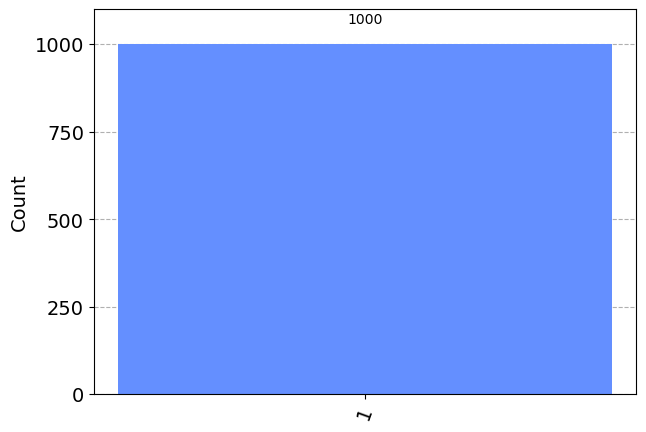

In [39]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend,shots=1000)
result = job.result()
plot_histogram(result.get_counts())

# Deutch's Josza

Classifico un funzione in bilanciata o costante

$
f(x):\{0,1\}^{n} \mapsto \{0,1\} 
$

- Bilanciata $ f(x) \neq f(y) \space \forall x,y \in \{0,1\}^n $ Metà input a 0 e metà a 1 (non tutti diversi)
- Costante $ f(x) = f(y) \space \forall x,y \in \{0,1\}^n $

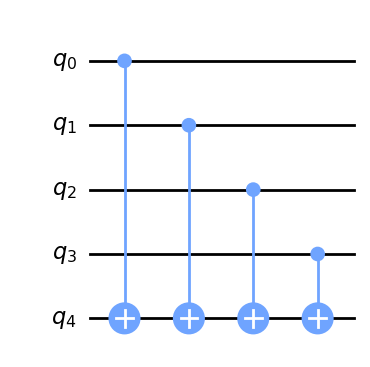

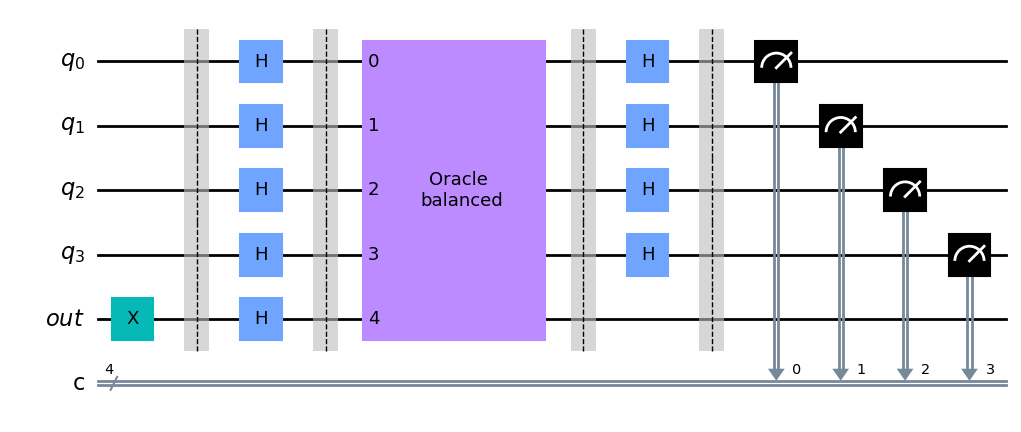

In [60]:
def deutch_josza_oracle(function_type, n, gate=True):
    oracle = QuantumCircuit(n+1)
    ancilla = n

    if function_type == "balanced":
        for qbit in range(n):
            oracle.cx(qbit, ancilla)

    elif function_type == "constant":
        if(not np.random.randint(2)):
            oracle.x(ancilla)

    if gate:
        oracle = oracle.to_gate()
        oracle.name = "Oracle \n" + function_type

    return oracle

N = 4
TYPE = "balanced"

display(deutch_josza_oracle(TYPE, N, gate=False).draw(output='mpl'))


qinput = QuantumRegister(N, 'q')
qoutput = QuantumRegister(1, 'out')
c = ClassicalRegister(N, 'c')
qc = QuantumCircuit(qinput, qoutput, c)

qc.x(qoutput)
qc.barrier()

qc.h(qinput)
qc.h(qoutput)
qc.barrier()


qc.append(deutch_josza_oracle(TYPE, N), range(N+1))
qc.barrier()

qc.h(qinput)
qc.barrier()

qc.measure(qinput, c)


qc.draw(output='mpl')


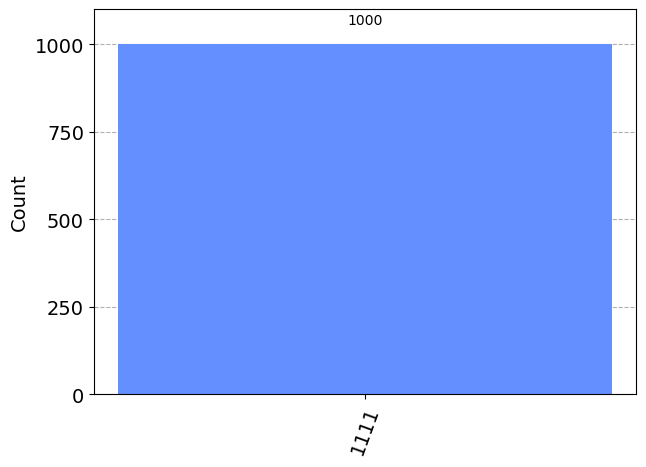

In [61]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend,shots=1000)
result = job.result()
plot_histogram(result.get_counts())

# Simon's
Classificazione funzioni periodiche. Supporta un algoritmo classico nella ricerca del periodo T della funzione.

$
f(x):\{0,1\}^n \mapsto \{0,1\}^n \\
\exists t \in \mathbb{R} : f(x) = f(x+t)
$  



Nella notazione in bit    


$
\exists c=c_0, \dots c_{n-1} : \quad \forall x,y \in \{0,1\}^n  \quad f(x)=f(x \oplus c)
$ 

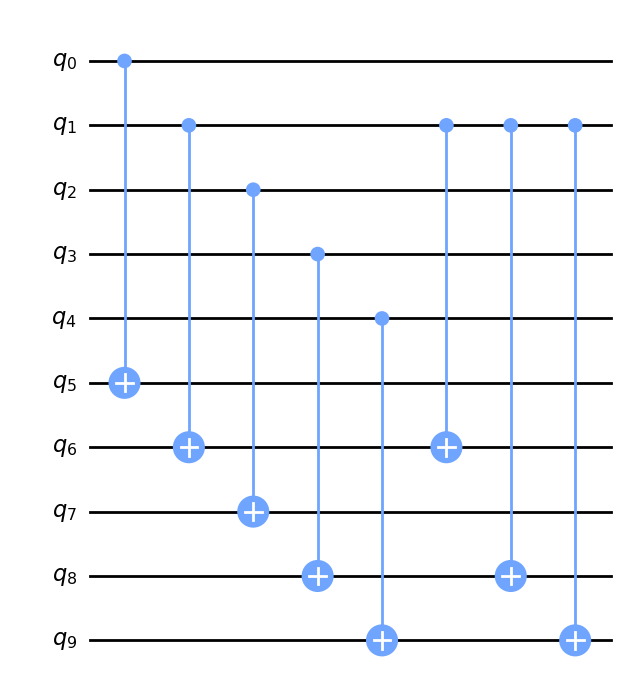

In [104]:
C = "11010"
N = len(C)
oracle = simon_oracle(C)
oracle.draw(output='mpl')

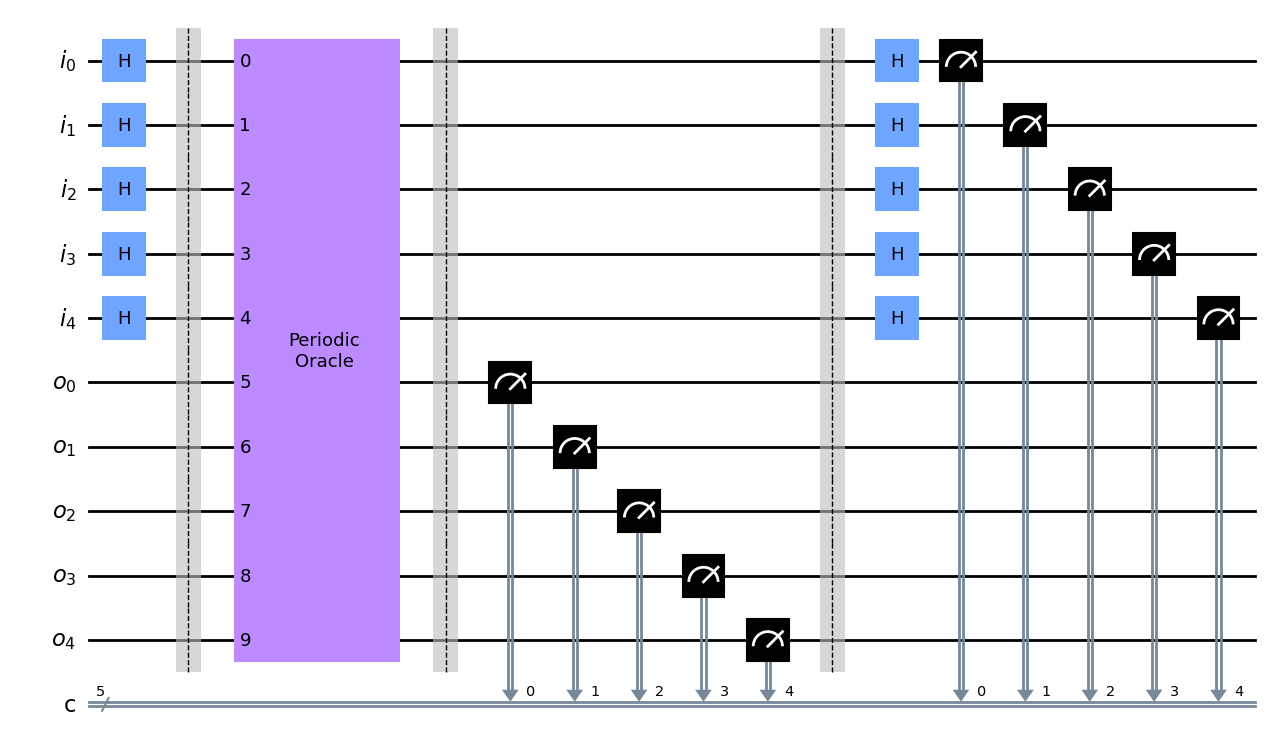

In [112]:
qinput = QuantumRegister(N, 'i')
qoutput = QuantumRegister(N, 'o')
c = ClassicalRegister(N, 'c')
qc = QuantumCircuit(qinput, qoutput, c)



qc.h(qinput)
qc.barrier()
qc.append(oracle.to_gate(label="Periodic\nOracle"), range(N*2))
qc.barrier()
qc.measure(qoutput, c)
qc.barrier()
qc.h(qinput)
qc.measure(qinput, c)

qc.draw(output = 'mpl')

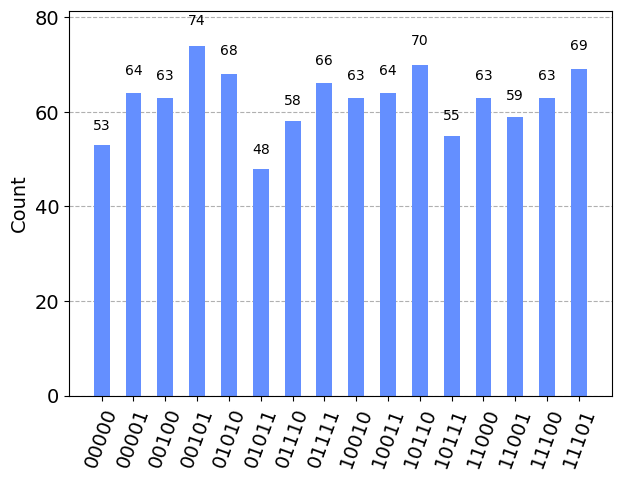

In [114]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend,shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)




In [116]:
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(C, z, bdotz(C,z)) )


11010.01110 = 0 (mod 2)
11010.11000 = 0 (mod 2)
11010.01010 = 0 (mod 2)
11010.11001 = 0 (mod 2)
11010.01111 = 0 (mod 2)
11010.10110 = 0 (mod 2)
11010.00100 = 0 (mod 2)
11010.11101 = 0 (mod 2)
11010.01011 = 0 (mod 2)
11010.00101 = 0 (mod 2)
11010.10011 = 0 (mod 2)
11010.10010 = 0 (mod 2)
11010.11100 = 0 (mod 2)
11010.00001 = 0 (mod 2)
11010.10111 = 0 (mod 2)
11010.00000 = 0 (mod 2)


# Grover
Ricerca di un elemento, definita tramite la funzione
$
f:\{0,1\}^n \mapsto \{0,1\} \quad f(x) = \begin{cases}
0 & \iff x \neq u \\
1 & \iff x = u
\end{cases}
$


Basato su: 
- PHASE INVERSION: se lo stato corrisponde alla soluzione inverto il segno dell'amplitude
- INVERSION AROUND AVERAGE: Riorganizzo le amplitude con somma e sottrazione della media


    - Calcolo la matrice della media $ A[i,j] = \frac{1}{n} $ con n dimensione dei dati tale che:  
    $
        v \in \mathbb{C}^n \quad Av = \text{Media in ogni posizione}
    $

    - Calcolo la matrice dell'inversion con $(-I_n + 2A)$
    - Calcolo il vettore invertito con $ V' = -V+2AV $


## Versione generica

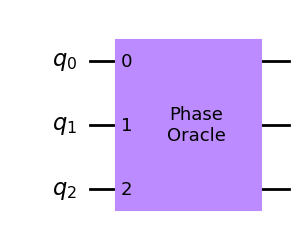

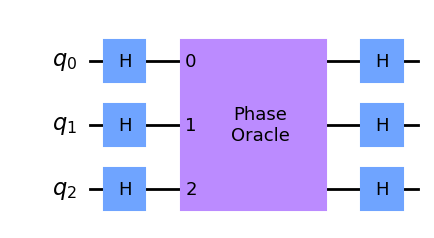

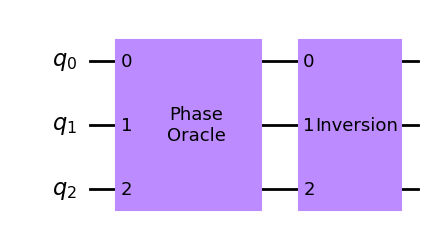

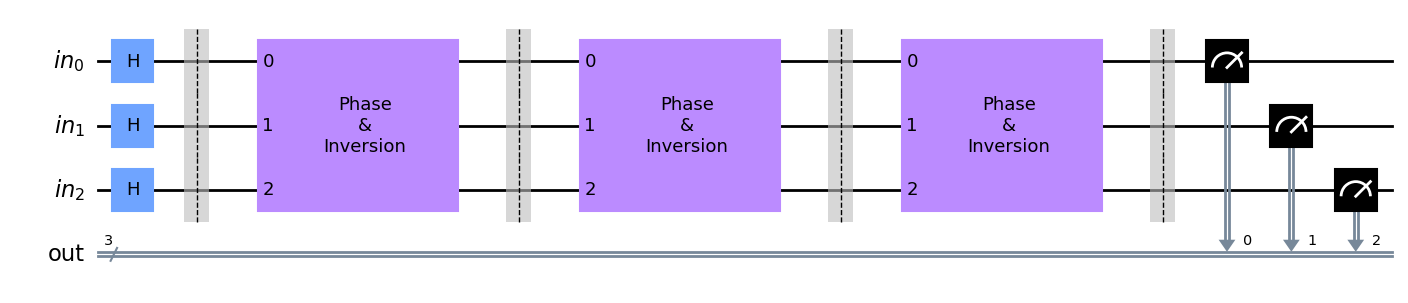

In [159]:
def phase_oracle(n, indices):
    oracle = QuantumCircuit(n)
    oracle_matrix = np.identity(2**n)
    for i in indices:
        oracle_matrix[i,i] = -1
    oracle.unitary(Operator(oracle_matrix), range(n),label="Phase\nOracle")
    return oracle

def inversion(n):
    inv = QuantumCircuit(n)
    inv.h(range(n))
    inv.append(phase_oracle(n, [0]).to_gate(label="Phase\nOracle"), range(n))
    inv.h(range(n))
    return inv

def grover_block(n, indices):
    grover = QuantumCircuit(n)
    grover.append(phase_oracle(n, indices=indices).to_gate(label="Phase\nOracle"), range(n))
    grover.append(inversion(n).to_gate(label="Inversion"), range(n))
    return grover

def grover_circuit(n, indices, repetitions):
    qinput = QuantumRegister(n, 'in')
    cout = ClassicalRegister(n, 'out')
    grover = QuantumCircuit(qinput,cout)

    grover.h(qinput)
    grover.barrier()
    
    for _ in range(repetitions):
        grover.append(grover_block(n, indices).to_gate(label="Phase\n&\nInversion"), range(n))
        grover.barrier()

    grover.measure(qinput, cout)
    return grover



display(phase_oracle(3, [1,2,1]).draw(output='mpl'))
display(inversion(3).draw(output='mpl'))
display(grover_block(3, [1,2]).draw(output="mpl"))
display(grover_circuit(3, [1,2], 3).draw(output="mpl"))
    

[3]


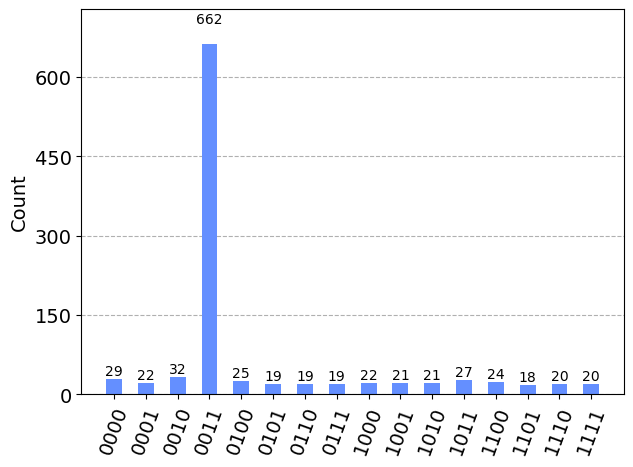

In [174]:
N = 4
x = np.random.randint(2**N)
indices = [x]
print(indices)
qc = grover_circuit(N, indices, 10)


backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend,shots=1000)
result = job.result()
plot_histogram(result.get_counts())


## Versione seguendo la teoria

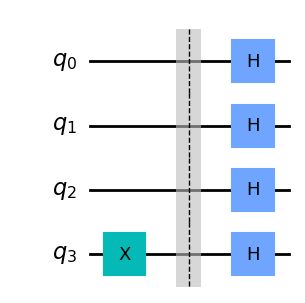

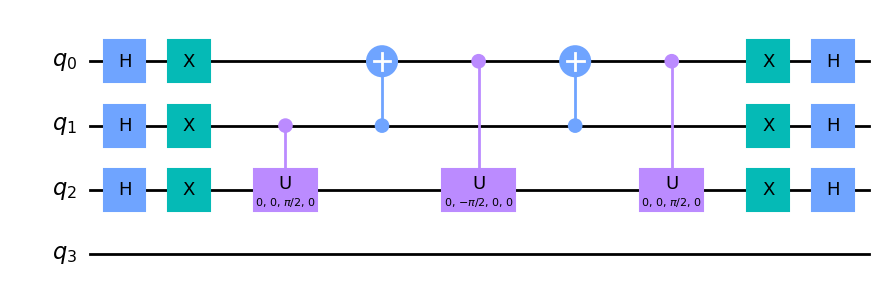

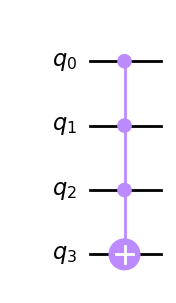

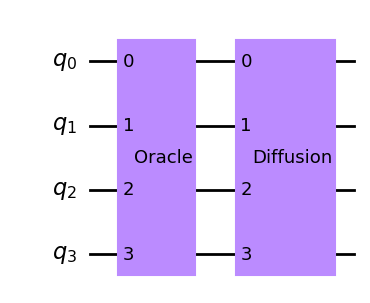

In [230]:
def state_preparation(qregister):
    n = len(qregister)
    prep = QuantumCircuit(n)
    prep.x(n-1)
    prep.barrier()
    prep.h(range(n))
    return prep


def diffusion(qregister):
    n = len(qregister)
    diff = QuantumCircuit(qregister)
    diff.h(range(n - 1))
    diff.x(range(n - 1))

    if(n > 2):
        diff.mcrz(np.pi, qregister[0:n-2], qregister[n-2])
    else:
        diff.z(0)
   
    diff.x(range(n-1))
    diff.h(range(n-1))
    
    return diff

def oracle(qregister):
    ora = QuantumCircuit(qregister)
    n = len(qregister)
    ora.mcx(qregister[0:n-1], qregister[n-1])
    return ora

def grover_block(qregister):
    gb = QuantumCircuit(qregister)
    gb.append(oracle(qregister).to_gate(label="Oracle"), qregister)
    gb.append(diffusion(qregister).to_gate(label="Diffusion"), qregister)
    return gb


N = 3
qreg = QuantumRegister(N+1, name='q')

display(state_preparation(qreg).draw(output="mpl"))
display(diffusion(qreg).draw(output="mpl"))
display(oracle(qreg).draw(output="mpl"))
display(grover_block(qreg).draw(output="mpl"))


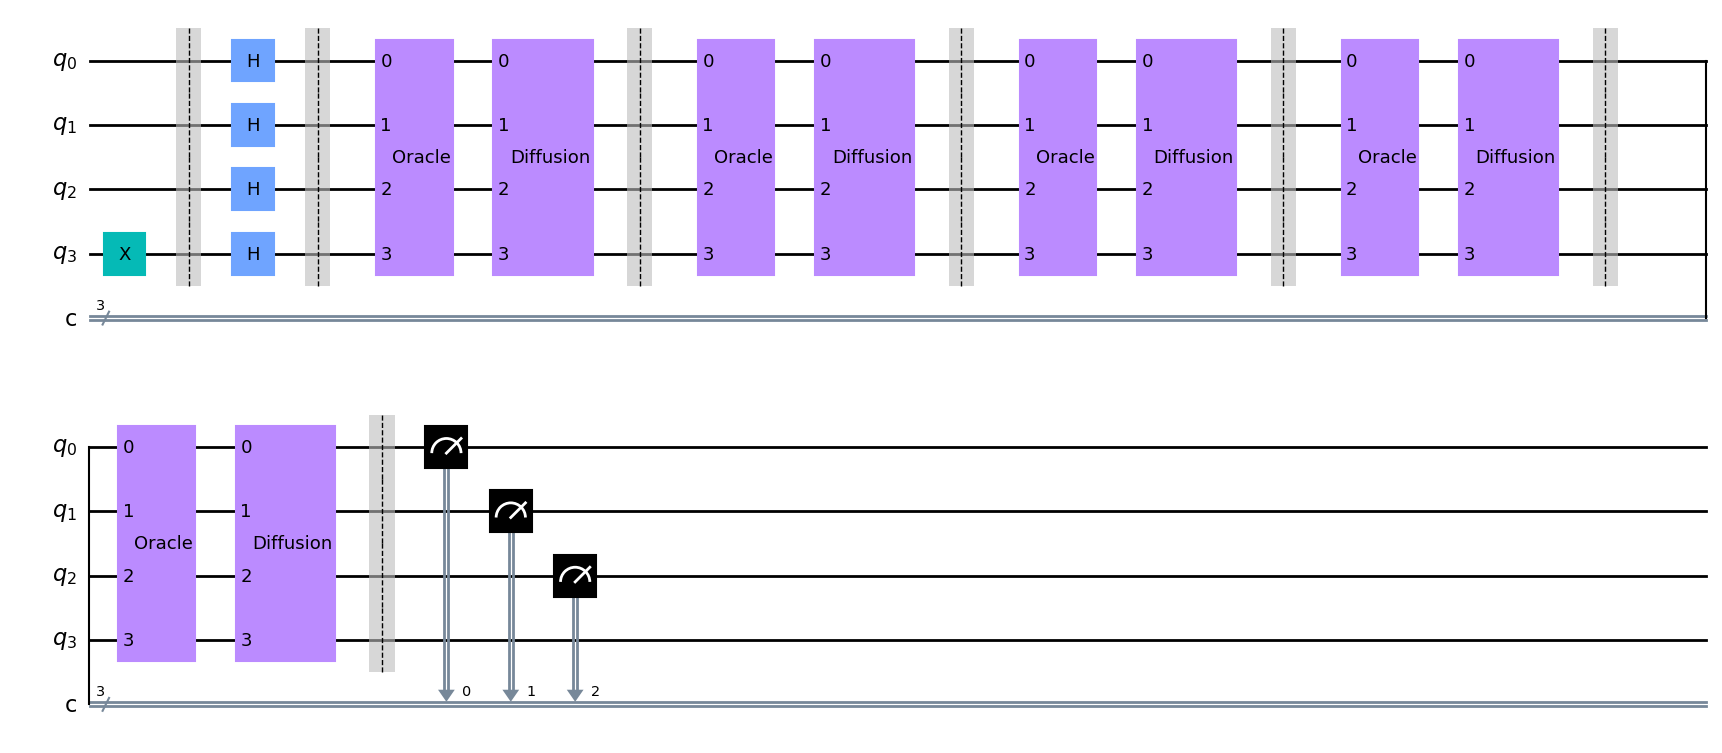

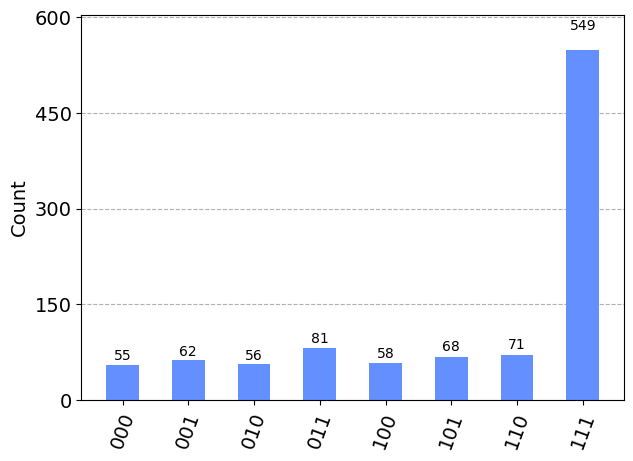

In [247]:
N = 3
IT = 5



qreg = QuantumRegister(N+1, name='q')
c = ClassicalRegister(N, name='c')
grover = QuantumCircuit(qreg, c)

grover = grover.compose(state_preparation(qreg), qreg)
grover.barrier()

for _ in range(IT):
    grover = grover.compose(grover_block(qreg), qreg)
    grover.barrier()

grover.measure(range(N), c)

display(grover.draw("mpl"))

backend = Aer.get_backend("qasm_simulator")
job = execute(grover, backend,shots=1000)
result = job.result()
plot_histogram(result.get_counts())